
# Training a SFNO on the spherical Shallow Water equations

In this example, we demonstrate how to use the small Spherical Shallow Water Equations example we ship with the package
to train a Spherical Fourier-Neural Operator


In [51]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import SFNO
from neuralop import Trainer
from neuralop.datasets import load_spherical_swe
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

from gc_src.gc_opt import GCOptimizer, WarmupScheduler

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Loading the Navier-Stokes dataset in 128x128 resolution



In [52]:
train_loader, test_loaders = load_spherical_swe(n_train=1000, batch_size=4, train_resolution=(64, 128),
                                                test_resolutions=[(32, 64), (64, 128)], n_tests=[50, 50], test_batch_sizes=[10, 10],)

Loading train dataloader at resolution (64, 128) with 1000 samples and batch-size=4
Loading test dataloader at resolution (32, 64) with 50 samples and batch-size=10
Loading test dataloader at resolution (64, 128) with 50 samples and batch-size=10


We create a tensorized FNO model



In [53]:
model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, projection_channels=64, factorization='dense')
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 277923 parameters.


Create the optimizer



In [54]:
base_optimizer = torch.optim.Adam(model.parameters(), 
                                lr=8e-4, 
                                weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(base_optimizer, T_max=30)
optimizer = GCOptimizer(base_optimizer, cont_var0 = 1e-6, cont_lr = 5e-2)
warmupscheduler = WarmupScheduler(optimizer, warmup_epochs=2)
# nan - 0.694, 0.688, 0.689, 0.687
# 1e-4 - 0.691
# 1e-5 - 0.69
# 1e-6 - 0.684, 0.691, 0.688

# warmup 2
# 1e-6 - 0.688

Creating the losses



In [55]:
l2loss = LpLoss(d=2, p=2, reduce_dims=(0,1))
# h1loss = H1Loss(d=2, reduce_dims=(0,1))

train_loss = l2loss
eval_losses={'l2': l2loss} #'h1': h1loss,

In [56]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 SFNO(
  (fno_blocks): FNOBlocks(
    (convs): SphericalConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexDenseTensor(shape=torch.Size([32, 32, 32]), rank=None)
      )
      (sht_handle): SHT(
        (_SHT_cache): ModuleDict()
        (_iSHT_cache): ModuleDict()
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv2d(3, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

### OPTIMIZER ###
 GCOptimizer (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0008
    lr: 0.00

Create the trainer



In [57]:
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)

self.override_load_to_device=False
self.overrides_loss=False


Actually train the model on our small Darcy-Flow dataset



In [58]:
'''trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)'''

'trainer.train(train_loader=train_loader,\n              test_loaders=test_loaders,\n              optimizer=optimizer,\n              scheduler=scheduler, \n              regularizer=False, \n              training_loss=train_loss,\n              eval_losses=eval_losses)'

In [59]:
for epoch in range(trainer.n_epochs):
    avg_loss = 0
    model.train()
    train_err = 0.0
    
    # track number of training examples in batch
    n_samples = 0

    for idx, sample in enumerate(train_loader):
        sample = {
            k: v.to(device)
            for k, v in sample.items()
            if torch.is_tensor(v)
        }

        n_samples += sample["y"].shape[0]

        def closure():
            # zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)

            # forward + backward
            out = model(**sample)
            loss = train_loss(out, **sample)
            loss.backward()
            del out

            return loss

        loss = optimizer.step(closure)
        train_err += loss.item()

        with torch.no_grad():
            avg_loss += loss.item()

    scheduler.step()
    warmupscheduler.step()

    train_err /= len(train_loader)
    avg_loss /= n_samples
    print(f'Epoch {epoch}, train loss: {avg_loss:.6f}, optim contvar: {torch.exp(optimizer.logcontvar).detach():.2e}, optim lr: {optimizer.param_groups[0]["lr"]:.2e}')

Epoch 0, train loss: 1.159812, optim contvar: 1.00e-06, optim lr: 7.98e-04
Epoch 1, train loss: 0.794583, optim contvar: 1.00e-06, optim lr: 7.91e-04
Epoch 2, train loss: 0.743648, optim contvar: 4.28e-08, optim lr: 7.80e-04
Epoch 3, train loss: 0.727284, optim contvar: 1.06e-08, optim lr: 7.65e-04
Epoch 4, train loss: 0.719313, optim contvar: 5.35e-09, optim lr: 7.46e-04
Epoch 5, train loss: 0.715269, optim contvar: 5.23e-09, optim lr: 7.24e-04
Epoch 6, train loss: 0.712408, optim contvar: 4.15e-09, optim lr: 6.97e-04
Epoch 7, train loss: 0.707458, optim contvar: 2.71e-09, optim lr: 6.68e-04
Epoch 8, train loss: 0.706297, optim contvar: 2.38e-09, optim lr: 6.35e-04
Epoch 9, train loss: 0.705270, optim contvar: 1.32e-09, optim lr: 6.00e-04
Epoch 10, train loss: 0.700638, optim contvar: 1.12e-09, optim lr: 5.63e-04
Epoch 11, train loss: 0.699402, optim contvar: 1.00e-09, optim lr: 5.24e-04
Epoch 12, train loss: 0.696326, optim contvar: 9.40e-10, optim lr: 4.83e-04
Epoch 13, train loss: 

Plot the prediction, and compare with the ground-truth 
Note that we trained on a very small resolution for
a very small number of epochs
In practice, we would train at larger resolution, on many more samples.

However, for practicity, we created a minimal example that
i) fits in just a few Mb of memory
ii) can be trained quickly on CPU

In practice we would train a Neural Operator on one or multiple GPUs



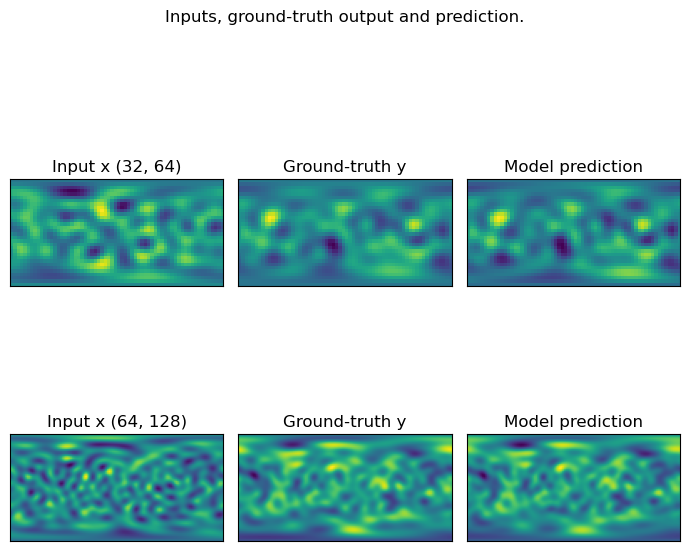

In [60]:
fig = plt.figure(figsize=(7, 7))
for index, resolution in enumerate([(32, 64), (64, 128)]):
    test_samples = test_loaders[resolution].dataset
    data = test_samples[0]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y'][0, ...].numpy()
    # Model prediction
    x_in = x.unsqueeze(0).to(device)
    out = model(x_in).squeeze()[0, ...].detach().cpu().numpy()
    x = x[0, ...].detach().numpy()

    ax = fig.add_subplot(2, 3, index*3 + 1)
    ax.imshow(x)
    ax.set_title(f'Input x {resolution}')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(2, 3, index*3 + 2)
    ax.imshow(y)
    ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(2, 3, index*3 + 3)
    ax.imshow(out)
    ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()